In [1]:
import os
import torch
from diffusers import StableDiffusionXLPipeline, DiffusionPipeline
from diffusers.utils import load_image, make_image_grid
from safetensors.torch import load_file
from PIL import Image


In [18]:
# 경로 설정
root = "/home/work/safetensors"
base_ckpt_path = os.path.join(root, "cartoonxl_v10.safetensors")
pk_trainer_path = os.path.join(root, "pk_trainer_xl_v1.safetensors")
sulgi_path = os.path.join(root, "SULGI_Ver_1.2-000010.safetensors")

# 기본 모델 로드
pipe = StableDiffusionXLPipeline.from_single_file(base_ckpt_path, torch_dtype=torch.float16).to('cuda')

Some weights of the model checkpoint were not used when initializing CLIPTextModelWithProjection: 
 ['text_model.embeddings.position_ids']


In [13]:
# LoRA 가중치 로드 및 적용
def load_and_apply_lora(pipe, lora_path, alpha):
    if os.path.exists(lora_path):
        lora_state_dict = load_file(lora_path, device="cuda")
        for key, value in lora_state_dict.items():
            if key in pipe.unet.state_dict():
                pipe.unet.state_dict()[key].add_(value * alpha)
    else:
        raise FileNotFoundError(f"Lora safetensors file not found at {lora_path}")

load_and_apply_lora(pipe, pk_trainer_path, 0.0)
load_and_apply_lora(pipe, sulgi_path, 1.0)



In [19]:
# 리파이너 모델 로드
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, use_safetensors=True
).to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [20]:

prompts = "cookie cartoon character, flat, clipart, illustration"
negative_prompt = "multiple tails, more than one tail, two tails, extra tails, three ears, four ears, extra ears, more than two ears, distorted body, misshapen body, disproportionate body, irregular body, twisted body, warped body, unnatural body"
steps = 35

  0%|          | 0/35 [00:00<?, ?it/s]

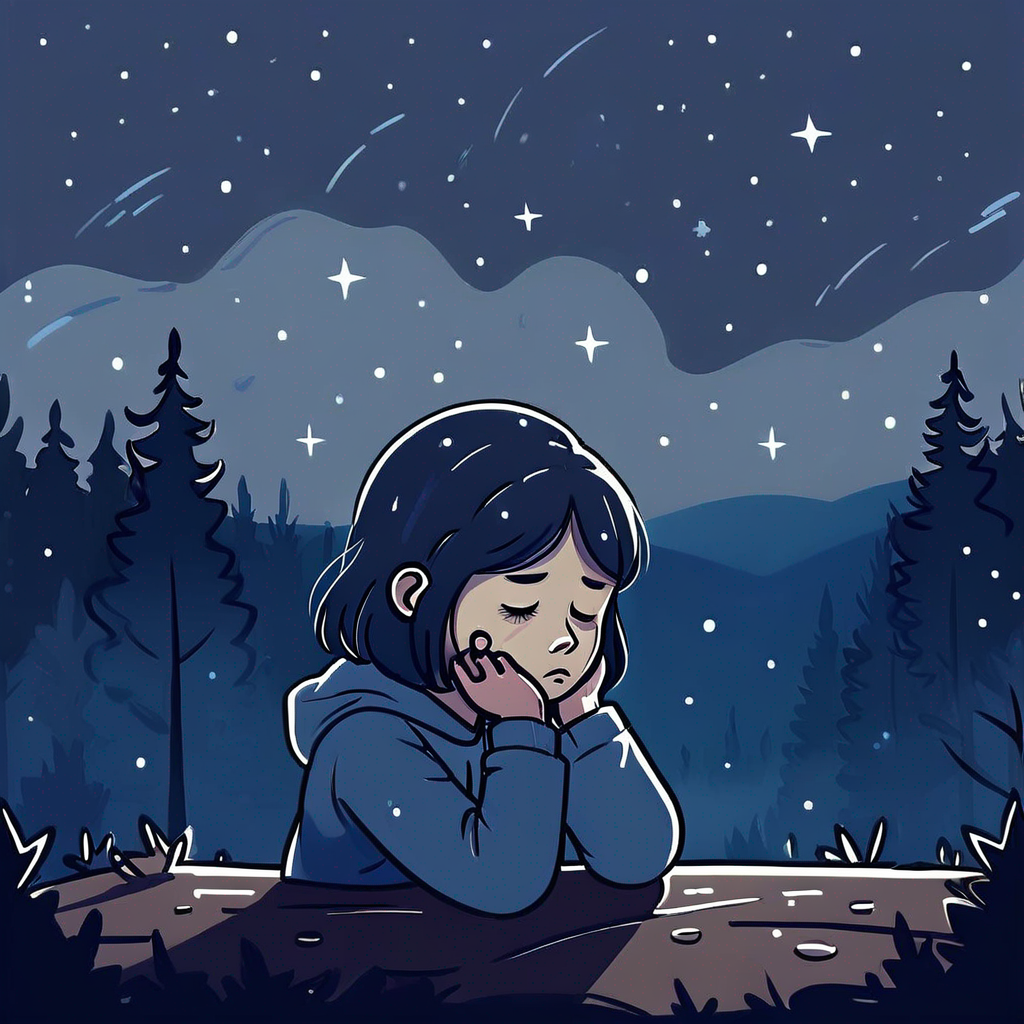

In [21]:
base_image = pipe(
    prompt=prompts, 
    negative_prompt=negative_prompt, 
    num_inference_steps=steps, 
    guidance_scale=7.2, 
)

latent_image = base_image.images[0]
latent_image.show()

  0%|          | 0/8 [00:00<?, ?it/s]

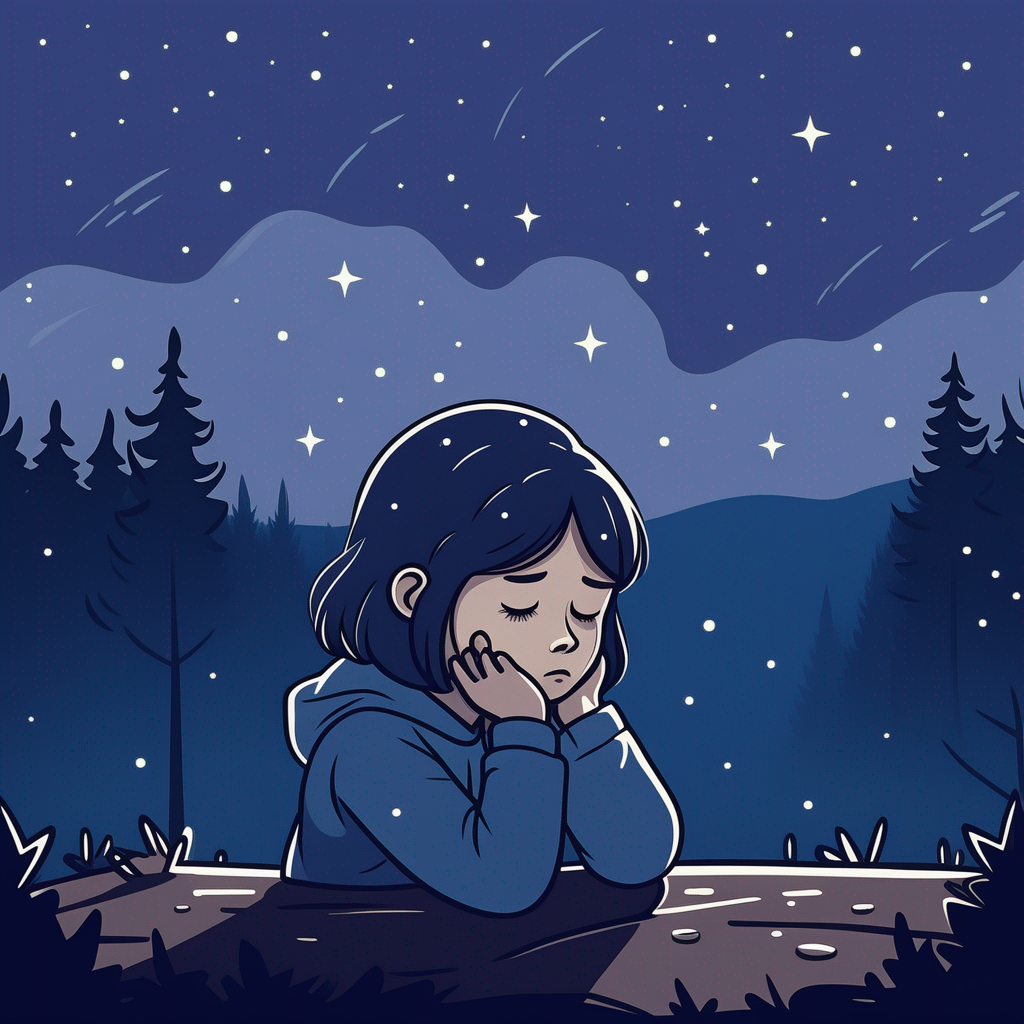

In [22]:
refine_image = refiner(
        prompt=prompts,
        num_inference_steps=steps,
        denoising_start=0.8,
        image=latent_image
)

refine_image = refine_image.images[0]
refine_image.show()